# Covariance Matrix Shrinkage for Portfolio Optimization

__This notebook demonstrates how and when estimation errors of the covariance matrix occur and approaches to reduce these errors.__ 


Inspired by the work of Ledoit & Wolf - _Honey, I Shrunk the Sample Covariance Matrix_, the covariance matrix of historical stock returns is 
1. estimated via the Ledoit-Wolf Shrinkage Estimator and the Oracle Approximating Shrinkage Estimator and 
2. used to compute the Markowitz' mean-variance portfolio. 
3. The results are then compared to the sample covariance and evaluated for 24 different time periods.  
<br> 

__Contents:__
1. Get Stock Price Data
2. Markowitz Portfolio Optimization
3. Singular Matrix
4. Shrinkage

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/time_series_analysis_2023/collected_code_internet/Covariance-Matrix-Shrinkage-for-Portfolio-Optimization-master/Covariance-Matrix-Shrinkage-for-Portfolio-Optimization-master")

Mounted at /content/drive


## Import Modules

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from datetime import datetime, timedelta
import os
import sys
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
%matplotlib inline

os.chdir("/content/drive/MyDrive/time_series_analysis_2023/collected_code_internet/Covariance-Matrix-Shrinkage-for-Portfolio-Optimization-master/Covariance-Matrix-Shrinkage-for-Portfolio-Optimization-master")

## 1. Get Stock Price Data
To get free stock price data from yahoo finance I'm going to use the `YahooFinancials` library, which is available at https://pypi.org/project/yahoofinancials/ . I've included a list with 750 ticker symbols, for which the adjusted closing prices from 3 years are downloaed and stored in a pandas dataframe.    

In [3]:
import yfinance as yf
import pandas as pd

def yahoo_single_ticker(ticker, start_date, end_date):
    '''
    Download stock price data (adj. close) from Yahoo Finance using yfinance
    
    Returns:
        Price series
    '''
    ticker = ticker.replace('.', '-')
    stock = yf.Ticker(ticker)
    prices = stock.history(start=start_date, end=end_date)
    prices = prices[['Close']]
    prices.columns = [ticker]
    return prices

def yahoo_multi_ticker(ticker_list, start_date, end_date):
    '''
    Download prices from multiple tickers
    
    Returns:
        Dataframe with a column for each ticker
    '''
    prices = pd.DataFrame()
    for ticker in ticker_list:
        try:
            prices = pd.concat([prices, yahoo_single_ticker(ticker, start_date, end_date)], axis=1)
        except Exception as e:
            print(f'Error while downloading {ticker}: {str(e)}')
        print(f'Downloaded {len(prices.columns)} tickers out of {len(ticker_list)}', end='\r')
    return prices

In [ ]:
ticker_list = pd.read_csv('ticker_list.csv', header=None).values.flatten()
print(ticker_list)
import sys
prices = yahoo_multi_ticker(ticker_list, 
                            start_date='2016-05-01',
                            end_date='2019-05-01')

### 1.1 Check for Missing Data 

In [9]:
prices.columns[prices.isnull().any()]
prices.dropna(axis=1, inplace=True)
prices.shape

(754, 636)

### 1.2 Calculate Log-Returns
Let's define $P_t$ as the price of asset $i$ at time $t$ and thus, $P_{t-1}$ the previous price of an asset, e.g. a stock. The logarithmic return  $r_t$ at $t$ is defined by:

\begin{align}
r_t =\ln\left(\frac{P_t}{P_{t-1}}\right) = \ln(P_t) - \ln(P_{t-1})
\end{align}

Since log-returns are subadditive, they are prefered to use instead of regular ones. For reasonable small numbers the log-returns and reglular ones are very close to each other. 

In [10]:
returns = np.log(prices/prices.shift())
returns.dropna(inplace=True)

# move S+P 500 Index into seperate dataframe
sp500 = returns['^GSPC']
returns.drop('^GSPC', axis=1, inplace=True)

returns.iloc[:5,:15]

,MAC,KMT,KMI,SLF,PEG,IPGP,HCA,BMRN,ENTG,PSEC,JSM,SSL,HSIC,DAL,HES
Date,,,,,,,,,,,,,,,
2016-05-03 00:00:00-04:00,0.002341,0.050977,-0.018939,-0.034394,-0.001734,-0.011850,-0.026831,-0.021049,-0.002206,-0.001347,-0.021130,-0.069927,-0.014490,0.017629,-0.038543
2016-05-04 00:00:00-04:00,0.013165,-0.033832,-0.006394,-0.009396,0.011863,-0.011401,0.009317,-0.035284,-0.007391,0.000000,0.004677,-0.020911,-0.010977,-0.035333,-0.025521
2016-05-05 00:00:00-04:00,0.010205,-0.022643,-0.000583,0.002737,-0.004082,-0.008547,0.010099,-0.017191,-0.028595,-0.006761,0.008774,0.030214,0.008423,0.007694,0.010072
2016-05-06 00:00:00-04:00,0.017114,0.007184,-0.017064,-0.004260,-0.016059,-0.001312,0.003591,0.000743,0.005329,0.001356,0.016310,-0.013986,0.011180,0.006922,0.004820
2016-05-09 00:00:00-04:00,0.006963,-0.054512,0.009451,-0.007039,0.010662,0.009032,0.000989,0.038602,0.003789,-0.013643,-0.008632,-0.032723,0.004285,0.011743,-0.030376


### 1.3 Split into In-Sample and Out-of-Sample Datasets

From the 754 trading days I'm going to use the first 500 (roughly 2 years) to fit a portfolio model, which is then evaluated on the last 254 trading days.

In [11]:
train = returns.iloc[:500]
print(train.shape)

test = returns.iloc[500:]
print(test.shape)

(500, 635)
(253, 635)


## 2. Markowitz Portfolio Optimization

The Markowitz portfolio optimization method aims to find an optimal basket of assets from a given _universe of assets_, made up of $N$ cosidered stocks . Its core concept is based on the (highly questionable) assumption that asset returns follow a normal distribution and thus, the assets in the universe a multivariate normal with mean vector $\mathbf{\mu}$, which consists of all the expected returns for the assets $\mathbb{E}[r_i]$, and covariance matrix $\mathbf{\Sigma}$, made up of the variances of the assets on the diagonal and the covariance between the assets anywhere else. This implies that assets exhibit correlations.  
<br>
  
According to the saying _do not put all eggs in one basket_, it is adviced to select a combination of assets that reduce the risk,  i.e. the volatility $\sigma_i = \sqrt{\mathbb{Var}[r_i]}$, by taking advantage of the assets correlations. It is possible to estimate an optimal selection of assets that either:

* Maximizes the return for a given level of risk,
* Minimizes the volatility for a given level of return
* Find an optimal trade-off between risk and return, the _mean-variance portfolio_

<br> 

In this notebook I'm going to implement the mean-variance portfolio, which aims to maximize the Sharpe ratio $\frac{r_i - r_{risk-free}}{\sigma_i}$. For simplicity I'm using here a risk-free rate of 0. The optimization problem is to estimate a weight vector $\mathbf{w}$, consisting of weight factors for all individual assets. Therefore the: 
* portfolio return $\mathbf{\mu}_{p}$ is $\mathbf{\mu^T  w}$
* portfolio variance $\mathbf{\sigma}^2_{p}$ is $\mathbf{w^T \Sigma  w}$  

Since estimating the expected future returns and (co)variances of assets is hard, the easiest method is to assume that the historical mean values for a given time period can be used as a proxy for future return / (co)variances.

In [12]:
def portfolio_return(mu, weights):
    '''
    Calculate expected portfolio returns for given weights
    '''
    if not len(mu) == len(weights):
        raise ValueError ('shape mismatch: weights and mu must be of same dimension')
        
    return np.dot(mu, weights)

def portfolio_variance(sigma, weights, std=True):
    '''
    Calculate expected portfolio variance (std=False) or standard deviation (std=True)
    '''
    if not len(sigma) == len(weights):
        raise ValueError ('shape mismatch: weights and sigma must be of same dimension')
        
    variance = np.dot(weights.T, np.dot(sigma , weights))
    if std:
        return np.sqrt(variance)
    else:
        return variance

def sharpe_ratio(mu, sigma, weights):
    mu_pf = portfolio_return(mu, weights)
    std_pf = portfolio_variance(sigma, weights)
    return mu_pf/std_pf

def portfolio_stats(mu, sigma, weights, annualize=True, print_out=True):
    if annualize:
        ann_factor = 252
        print_str = 'annual'
    else:
        ann_factor = 1 
        print_str = 'daily'
        
    mu_pf = portfolio_return(mu, weights)*ann_factor
    std_pf = portfolio_variance(sigma, weights)*np.sqrt(ann_factor)
    sharpe = mu_pf/std_pf
    
    if print_out:
        print('Expected {}: \n return: {:.4f} \n volatility: {:.4f} \n Sharpe-ratio: {:.4f}'.format(
        print_str, mu_pf, std_pf, sharpe))
    
    return [mu_pf, std_pf, sharpe]

In [13]:
mu = np.mean(train).values
sigma = np.cov(train, rowvar=False)

### 2.1 Equally Weighted Portfolio
To get an intuition about how the optimiation actually improves the results, the equally weighted portfolio serves as a benchmark. It simply holds all the assets in the universe with same proportions $w_i = \frac{1}{N}$.  

In order to better interprete the results the portfolio statistics here have been annualised with a constant factor of 252, which represents an average number of trading days. Note that the volatity needs to be annualised by $\sqrt{252}$, since it is the squared root of the variance.

In [14]:
n = mu.size
weights_equal = np.repeat(1/n, n)

_ = portfolio_stats(mu, sigma, weights_equal)

Expected annual: 
 return: 0.1686 
 volatility: 0.1189 
 Sharpe-ratio: 1.4180


### 2.2 Minimum-Variance Portfolio
The optimization problem here is:

\begin{split}\begin{array}{lrcl}
\mbox{minimize}_{\mathbf{w}}   & \frac{1}{2} \mathbf{w}^T \mathbf{\Sigma} \mathbf{w}       &        &\\
\mbox{subject to} &  \mathbf{w}^T       & =      & \mathbf{\mu}_{p}\\
                  &  \mathbf{w}^T \mathbf{1} & =  & 1\\
                  &  w_i & \geq   & 0\\
\end{array}\end{split}
where $\mathbf{1}$ is a vector of 1's, ensuring that all the weights add up to 1.  
To prevent short-selling, i.e. having negative  weights, each weight $w_i$ is restricted to be within $\geq 0$. Since every change in constraints can have a huge impact on the estimated weights, I've decided to not restrict the individual weights to certain boundaries, which might not be optimal but should lead to more comparable results. 

This quadratic optimization problem can be solved by e.g. using Sequential Least Squares Programming (SLSQP), which is already implemented in `scipy`. 

In [16]:
def optimize_mean_var(mu, sigma):
    '''
    Mean-variance portfolio optimization with SLSQP
    
    Returns
        Optimal weights
    '''    
    if not isinstance(mu, np.ndarray):
        mu = np.array(mu)        
    
    def objective_f(weights):
        return - sharpe_ratio(mu, sigma, weights)    
    
    n = mu.size

    # Constraints: sum of weights = 1
    cons = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1.})
    # Boundaries: 0 =< weights =< 1 (only long positions)
    bnds = tuple((0, 1) for x in range(n))
    # initial guess: equal weights
    x_0 = np.repeat(1/n, n)
    # Sequential Least SQuares Programming (SLSQP)
    opts = minimize(objective_f, x0=x_0, method='SLSQP', bounds=bnds, constraints=cons)
    if opts['message'] != 'Optimization terminated successfully.':
        print(opts['message'])
    
    return opts['x']


def get_portfolio_stocks(weights):
    selected_idx = np.nonzero(weights.round(4))
    selected_tickers = np.array(list(returns))[selected_idx]
    selected_weights = weights[selected_idx]
    return pd.DataFrame(selected_weights, index=selected_tickers, columns=['weight'])


def plot_pf_weights(pf_tickers, figsize=(12,6)):
    fig, ax = plt.subplots(figsize=figsize)
    pf_tickers.plot(kind='barh', ax=ax, legend=False);
    plt.title('Portfolio Weights > 0', fontweight='bold')
    fig.tight_layout()
    fig.show();

Optimization terminated successfully
635
Expected annual: 
 return: 0.4421 
 volatility: 0.1005 
 Sharpe-ratio: 4.3975
CPU times: user 49.2 s, sys: 12 s, total: 1min 1s
Wall time: 46.7 s


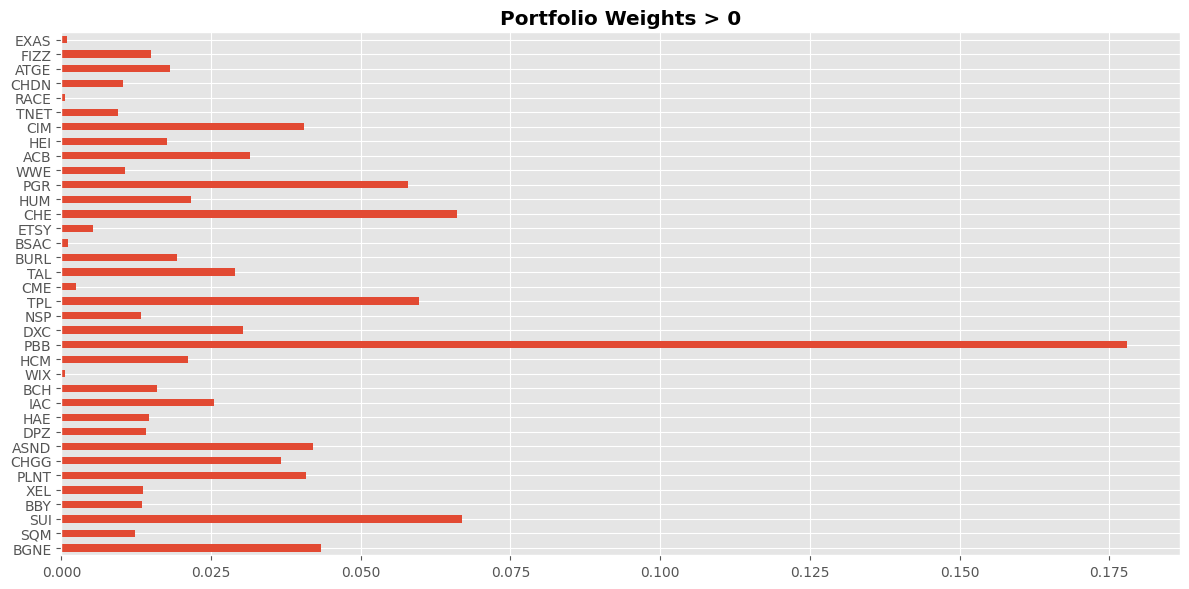

In [17]:
%%time

weights_mv = optimize_mean_var(mu, sigma)
print(len(weights_mv))
_ = portfolio_stats(mu, sigma, weights_mv)

pf_tickers_mv = get_portfolio_stocks(weights_mv)

plot_pf_weights(pf_tickers_mv)

Compared to the equally weighted portfolio, the performance has been improved significantly, achieving a higher return with a lower risk.

### 2.3 Evaluate Performance
Clearly, it is easy to tell what would have been the best combination of assets in the past, i.e. after observing all the returns. To evaluate if the past can be used as a good proxy for the future, I've plotted the cummulative portfolio return for the in-sample period, for which the weights have been estimated and the out-of-sample period, i.e. the period that the optimizer hasn't seen.

In [21]:
def add_day(date_idx):
    '''
    Append one extra day at beginning of datetime index
    
    Input
        date_idx = returns.index.values
    Returns
        date_idx
    '''
    offset = min(date_idx) - np.timedelta64(1, 'D')
    return np.hstack([offset, date_idx])

def cum_return(weights, returns):
    '''
    Calculate cummulative portfolio return for given weigthts
    '''
    pf_return = np.dot(weights, returns.T)
    # print(weights.shape)
    pf_return = pd.concat([pd.Series([1]),
                           pd.Series(pf_return).cumsum()+1])
    # print(pf_return.shape)
    pf_return.index = add_day(returns.index.values)
    return pf_return

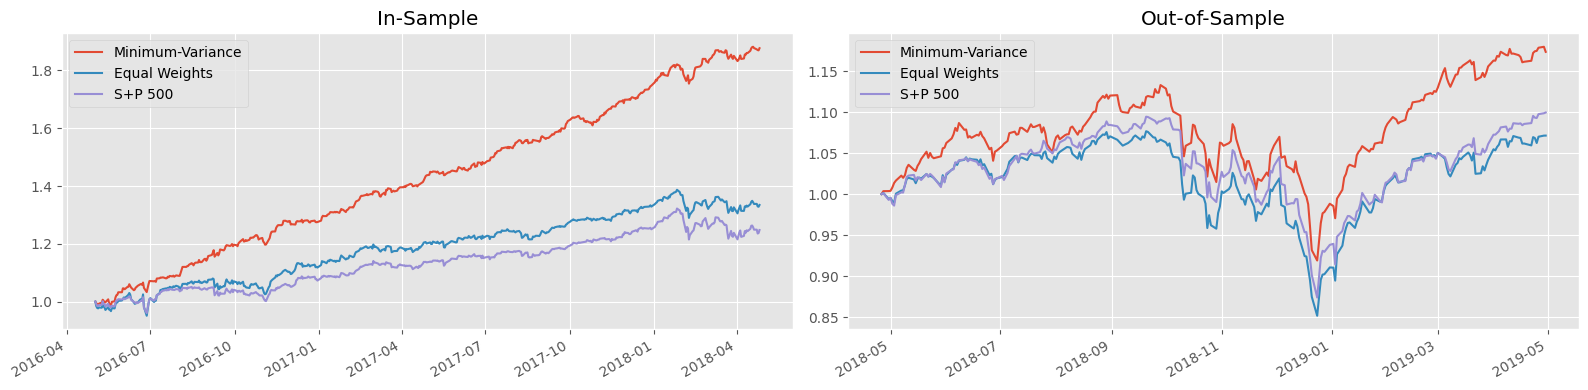

Final Dollar-Value In-Sample: 
 Minimum-Variance    1.877084
Equal Weights       1.334590
S+P 500             1.247877
Name: 2018-04-26 00:00:00-04:00, dtype: float64 

Final Dollar-Value Out-of-Sample: 
 Minimum-Variance    1.173390
Equal Weights       1.071313
S+P 500             1.099459
Name: 2019-04-30 00:00:00-04:00, dtype: float64


In [38]:
train_ret = pd.DataFrame()
train_ret['Minimum-Variance'] = cum_return(weights_mv, train)
train_ret['Equal Weights'] = cum_return(weights_equal, train)
train_ret['S+P 500'] = cum_return(1, sp500.iloc[:500])

test_ret = pd.DataFrame()
test_ret['Minimum-Variance'] = cum_return(weights_mv, test)
test_ret['Equal Weights'] = cum_return(weights_equal, test)
test_ret['S+P 500'] = cum_return(1, sp500.iloc[500:])


# plot
fig, ax = plt.subplots(1,2, figsize=(16,4))
train_ret.plot(ax=ax[0])
ax[0].set_title('In-Sample')
test_ret.plot(ax=ax[1])
ax[1].set_title('Out-of-Sample')
fig.tight_layout()
plt.show();


print(f'Final Dollar-Value In-Sample: \n {train_ret.iloc[-1]} \n')
print(f'Final Dollar-Value Out-of-Sample: \n {test_ret.iloc[-1]}')

The dollar-value tells us how much the portfolio would be worth for investing 1 dollar at the beginning of the period. As we can see, the mean-variance portfolio outperforms the equally weighted and S+P 500 index for the in-sample and out-of-sample period substantially.

## 3. Singular Matrix
In the previous section, the historical covariance matrix has been estimated by simply using the asset returns and the sample covariance function $\mathbf{\Sigma} = \mathbf{E}(r-\mu)(r-\mu)^T$. 

While this works fine for a small number $N$ of assets and a large time period $T$, it becomes an issue if $N \ge  T$, i.e. if one has more assets (columns in the covariance matrix) than included returns (rows).  

For the purpose of portfolio optimization it typically does not make sense to include a large number of historical asset returns, e.g. 10 or 20 years daily returns, since the market regimes / underlying factors change too much over time. Thus, it is advised to incorporate only a limited number of time periods. However, there is often no reason to limit the number of included assets (the _universe_) in the optimization process, e.g. one might consider 1000's of assets. As a result, it is quite common to have more assets than time periods and hence $N \ge T$.  

The issue is that the covariance matrix becomes _singular_. A singular matrix does not have an inverse $\mathbf{\Sigma}^{-1}$ and its determinant $det(\mathbf{\Sigma}) = 0$. The problem with a singular covariance matrix is that it is suffers from numerical instability, i.e. the estimation errors increase significantly.   

For computional reasons it is hard to calculate the determinate of a large matrix, but for demonstration purposes I've calculated the _Condition Number_ $\kappa$, which is defined for a matrix $\mathbf{A}$ by:

\begin{align}
\kappa(A) \ = \  \|A\| \|A^{-1}\| \:,
\end{align}

where $\|\cdot\|$ is the _Euclidean norm_, $\|x\| \ = \ (\sum_i x_i^2)^{1/2}$.

If $\mathbf{A}$ is singular, $\kappa = \infty \:$.  

In the plot below is the logarithm of the sample covariance matrix for different number of assets. Remember that the (train) dataset contains $t = 500$ asset returns for each asset (rows), it can be easily seen that the Condition Number explodes after including more than 500 assets (columns), which indicates a (close to) singular matrix. 

Note that this is log scaled, and some true number for $n$ included assets are:
* $n=100$ : $\kappa \approx 620$
* $n=499$ : $\kappa \approx 7,319,078,722$
* $n=500$ : $\kappa \approx 9.7639 \times 10^{18}$
* $n=746$ : $\kappa \approx 4.324 \times 10^{20}$

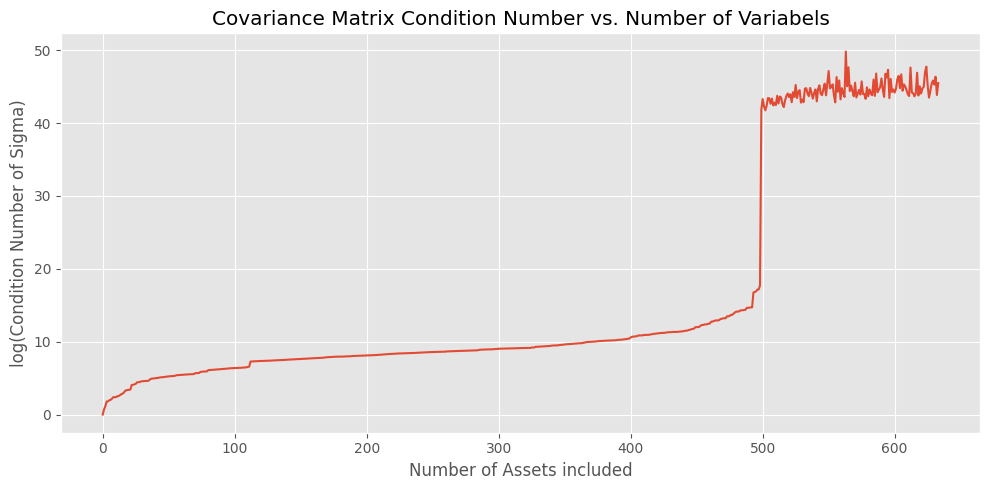

In [23]:
c = []
for i in range(1, train.shape[1]):
    c.append(np.linalg.cond(train.iloc[:,:i].cov().values))    
    
plt.figure(figsize=(10,5))
plt.plot(range(len(c)), np.log(c));
plt.title('Covariance Matrix Condition Number vs. Number of Variabels')
plt.xlabel('Number of Assets included')
plt.ylabel('log(Condition Number of Sigma)')
plt.tight_layout();

A covariance matrix is per definition _positive-semidefinite_, i.e.

\begin{align}
\mathbf{v}^T \mathbf{\Sigma}\mathbf{v}\geq 0, \qquad \forall \mathbf{v} \in \mathbb{R}^{n}
\end{align}

This also implies that $\mathbf{\Sigma}$ has only positive eigenvalues $\lambda$.

The function `is_pos_def` is used to return True, if all eigenvalues are $\ge 0$ and False, otherwise.  
It can be seen that it returns False if $N \ge T$, while True if $N < T$ .

In [24]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

is_pos_def(sigma)

False

In [25]:
is_pos_def(train.iloc[:,:500].cov().values)

True

ommitted 25 days from 500, that's just 5% of the entire data. Still enough the change the results.

### 3.1 Covariance Matrix Instability
The issue of numerical instability is that small changes in the input data, e.g. the returns here, lead to siginificant differences in the estimated covariance matrix.  

Below is a heatmap that shows the first $10 \times 10$ rows and column from the estimated covariance matrix if all 500 time periods are included on the left side and if only 475 time periods are considered on the right side.  

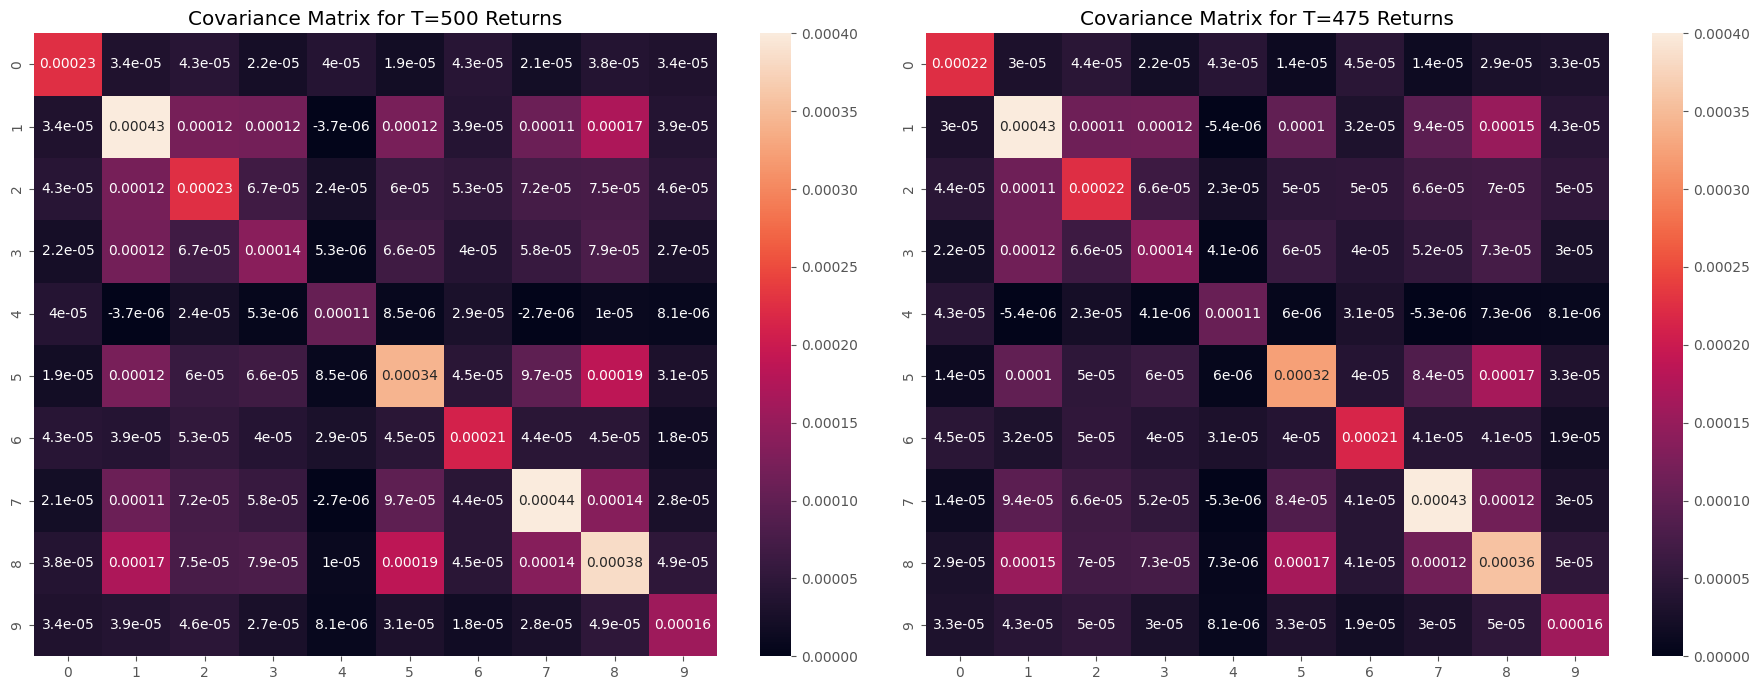

In [26]:
prune_idx = 475

cov_full = train.cov().values[:10, :10]
cov_prune = train.iloc[:prune_idx].cov().values[:10, :10]

fig, ax = plt.subplots(1, 2, figsize=(18, 7))
sns.heatmap(cov_full, annot=True, ax=ax[0], vmin=0, vmax=.0004)
ax[0].set_title('Covariance Matrix for T=500 Returns')
sns.heatmap(cov_prune, annot=True, ax=ax[1], vmin=0, vmax=.0004)
ax[1].set_title('Covariance Matrix for T=475 Returns')
fig.tight_layout();

While the numbers actually don't seem to be that dramatic, it needs to be mentioned that the (co)variances over two years should be pretty stable, i.e. ommitting 25 days ($ = 5\%$ of $T$ shouldn't change the covariance matrix much.  
The main issue with the changes in the covariance matrix is that even small changes can have a huge impact on the portfolio optimization process, i.e. resulting in substantial different weights.  

In [27]:
mu_475 = np.mean(train.iloc[:475]).values
sigma_475 = np.cov(train.iloc[:475], rowvar=False)

weights_475 = optimize_mean_var(mu_475, sigma_475)
_ = portfolio_stats(mu_475, sigma_475, weights_475)

Optimization terminated successfully
Expected annual: 
 return: 0.4751 
 volatility: 0.0985 
 Sharpe-ratio: 4.8236


Running the same optimization with only $T = 475$ instead of the above used $T = 500$ shows clearly how the small changes have a large impact on the estimated weights, as plotted below.

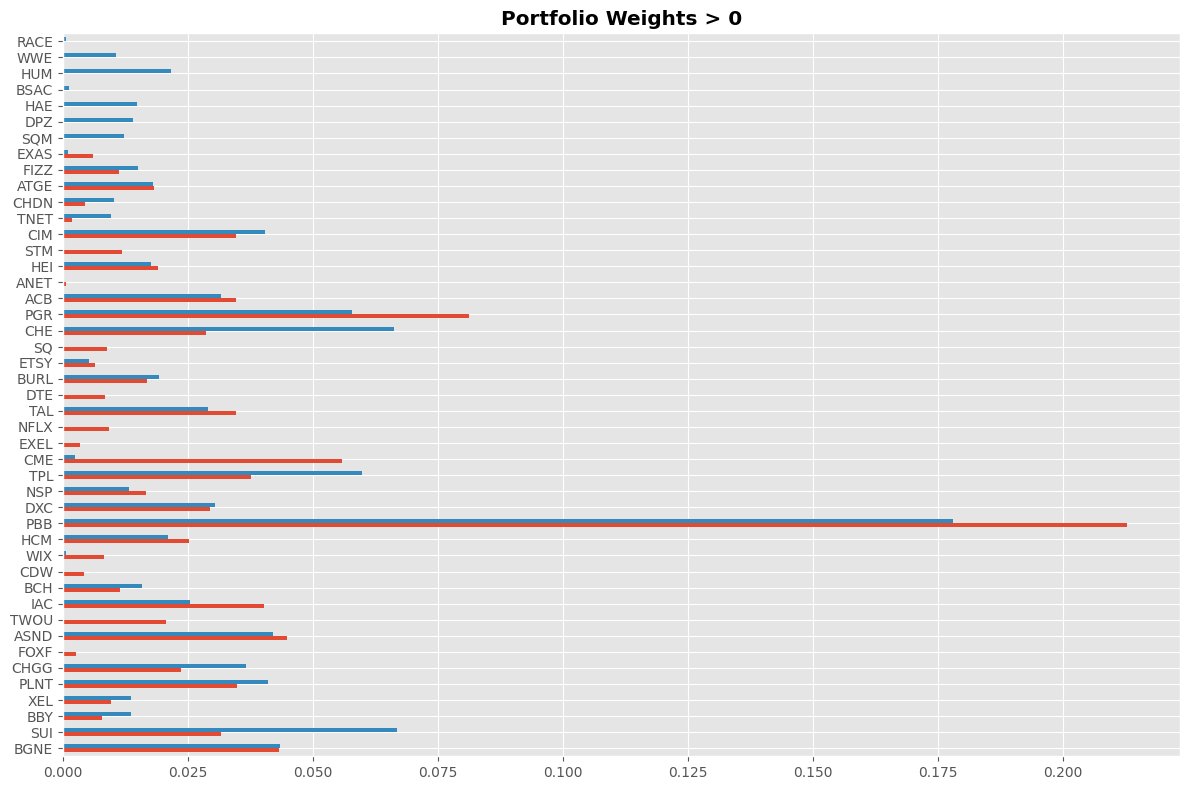

In [28]:
plot_pf_weights(pd.concat([get_portfolio_stocks(weights_475), 
                get_portfolio_stocks(weights_mv)], axis=1),
                figsize=(12, 8))

## 4. Shrinkage
To overcome the issue of large estimation errors in singular covariance matrices, the popular _shrinkage_ method has been proposed. The key idea is to create an weighted average of the sample covariance matrix $\mathbf{\hat\Sigma}$ and a target matrix $\mathbf{F}$. It exists a range of different proposed target matrices, which include e.g. principal components (PCA) or factor models (e.g. Fama-French-Model). A more simple approach is the from Ledoit & Wolf introduced target matrix 

\begin{align}
\mathbf{F} = \frac{tr(\hat\Sigma)}{N} \mathbf{I} \: ,
\end{align}

where $\mathbf{I}$ denotes the identity matrix and $tr(A) = \sum_{i=1}^n a_{ii}$ the _trace_ of a square ($n \times n$) matrix. Thus, $\mathbf{F}$ only has elements on its diagonal.  

The goal is now to estimate an optimal value for the parameter $\delta$, which controlls the shrinkage intensity, i.e. how much signal is used from each, the sample covariance and target, matrix. This leads to:

\begin{align}
\mathbf{\Sigma}_{shrunk} = (1-\delta){\mathbf{\hat\Sigma}} + \delta \: \frac{tr(\mathbf{\hat\Sigma)}}{N} \mathbf{I}
\end{align}

Below is a visulization of different levels for $\delta$. Not that the function `shrink_cov` is equivalent to scikit learn's `covariance.ShrunkCovariance`.

In [29]:
def shrink_cov(sigma, delta):
    n = sigma.shape[0]
    target = np.dot(np.identity(n), np.trace(sigma)) / n
    sigma_shrink = delta*target + (1-delta)*sigma
    return sigma_shrink

def plot_heat(sigma, limit=50, vmax=.0005):
    return sns.heatmap(sigma[:limit, :limit], cmap='viridis', vmin=0, vmax=vmax)

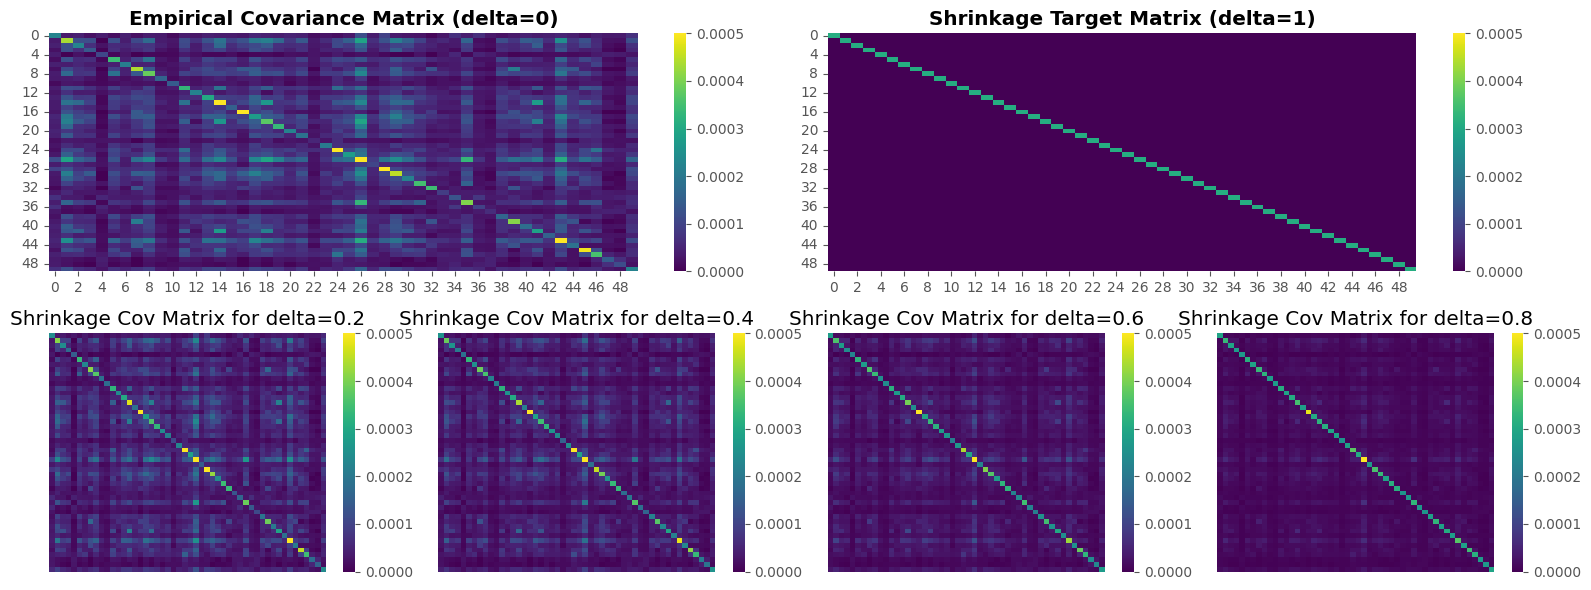

In [30]:
fig = plt.figure(figsize=(16, 6)) 
gs = gridspec.GridSpec(2, 4) 

ax0 = plt.subplot(gs[0,:2])
ax0 = plot_heat(shrink_cov(sigma, 0))
ax0.set_title('Empirical Covariance Matrix (delta=0)', fontweight='bold')

ax1 = plt.subplot(gs[0,2:])
ax1 = plot_heat(shrink_cov(sigma, 1))
ax1.set_title('Shrinkage Target Matrix (delta=1)', fontweight='bold')

for idx, delta in enumerate([.2, .4, .6, .8]):
    ax = plt.subplot(gs[1, idx])
    ax = plot_heat(shrink_cov(sigma, delta))
    ax.set_title(f'Shrinkage Cov Matrix for delta={delta}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

fig.tight_layout();

### 4.1 Shrinkage Methods
The problem of estimating an optimal value for the $\delta$ parameter is non-trivial, since one cannot observe the true covariance matrix.  
To compare different methods I've choosen to use the Ledoit-Wolf Estimator (LW) and the Oracle Approximating Shrinkage Estimator (OAS), which are both already implemented scikit-learn. Since the mathematical justifications are rather extensive, I've not included them here, but the research papers can be found at the end of this notebook in the references [2] Ledoit and Wolf, as well as [3] Chen et. al.

Scikit-learn also offers another robust estimator `covariance.MinCovDet`, the Minimum Covariance Determinant (MCD). However, the results for the used dataset here were hardly different from the empirical covariance matrix and thus, have been excluded for computional reasons.  

In order to perform an experiment about how the results from the different methods _Empirical Covariance, LW_ and _OAS_ differ, I've :
* Estimate the covariance matrix $\mathbf{\Sigma}$ with each of them for 251 days of returns (approx. one year of trading days).
* Use the estimated $\mathbf{\Sigma}$ to compute the weights for the mean-variance portfolio. 
* Calculate the cummulative returns for the in-sample period and the following 21 days (approx. one month of trading days) as out-of-sample period.
* Create a sliding window, i.e. shift the in-sample and out-of-sample period by 21 days and repeat the previous steps. 

I've used the entire 754 trading days, which results in 24 different time windows.  
Note: This means the portfolio optimization is performed $24 \times 3 = 72$ times, which might take a while.

In [31]:
from sklearn.covariance import LedoitWolf, ShrunkCovariance, OAS

def cov_lw(X):
    obj = LedoitWolf().fit(X)
    return obj.covariance_

def cov_oas(X):
    obj = OAS().fit(X)
    return obj.covariance_

def compute_cov_matrices(X):
    empirical = np.cov(X, rowvar=False)
    lw = cov_lw(X)
    oas = cov_oas(X)
    return (empirical, lw, oas)

In [32]:
cov_methods = ['Empirical', 'LW', 'OAS']

window_size = 21
n_periods = int(np.ceil((returns.shape[0]-251)/window_size))

results = {} 
for k in range(n_periods): 
    # sliding window
    i = k*window_size
    in_sample = returns.iloc[i:i+251, :].copy()
    out_of_sample = returns.iloc[i+251:i+251+window_size, :].copy()
    
    # compute covariance matrices
    cov_matrices = compute_cov_matrices(in_sample)
    
    # fit portfolio model
    mu = np.mean(in_sample).values
    pf_fit = {}
    for idx, sigma in enumerate(cov_matrices):        
        weights = optimize_mean_var(mu, sigma)
        
        pf_data = {}
        pf_data['return_is'] = cum_return(weights, in_sample)
        pf_data['return_oos'] = cum_return(weights, out_of_sample)
        pf_data['stats'] = portfolio_stats(mu, sigma, weights, print_out=False)
        pf_data['weights'] = weights 
        
        idx = cov_methods[idx]
        pf_fit[idx] = pf_data
    
    # store results
    results[k] = pf_fit
    
    # print status
    sys.stdout.write('\r')
    sys.stdout.write(f'Computations for window {k+1} of {n_periods} successfully.')
    sys.stdout.flush()

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Computations for window 1 of 24 successfully.Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Computations for window 2 of 24 successfully.Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Computations for window 3 of 24 successfully.Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Computations for window 4 of 24 successfully.Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Computations for window 5 of 24 successfully.Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Computations for window 6 of 24 successfully.Optimization terminated successfully
Optimization terminated suc

In [ ]:
#np.save('results.npy', results)

In [33]:
results_eval = {}
for method in cov_methods:

    results_df = pd.DataFrame(index=range(1, n_periods+1))
    results_df['dollar_val_is'] = [results[k][method]['return_is'].iloc[-1] for k in results]
    results_df['dollar_val_oos'] = [results[k][method]['return_oos'].iloc[-1] for k in results]
    
    pf_stats = np.array([results[k][method]['stats'] for k in results])
    results_df['pf_mu'] = pf_stats[:, 0]
    results_df['pf_std'] = pf_stats[:, 1]
    results_df['pf_sharpe'] = pf_stats[:, 2]
    
    pf_weights = np.array([results[k][method]['weights'].round(4) for k in results])
    pf_weights_stats = []
    for w in pf_weights:
        non_zero_w = w[np.nonzero(w)]
        pf_weights_stats.append([non_zero_w.size, non_zero_w.min(), non_zero_w.max()])
        
    pf_weights_stats = np.array(pf_weights_stats)
    results_df['weights_count'] = pf_weights_stats[:, 0]
    results_df['weights_min'] = pf_weights_stats[:, 1]
    results_df['weights_max'] = pf_weights_stats[:, 2]
    
    results_eval[method] = results_df

At first, let's evaluate some important metrics on how the portfolios perform over time, i.e. for each of the 24 windows.

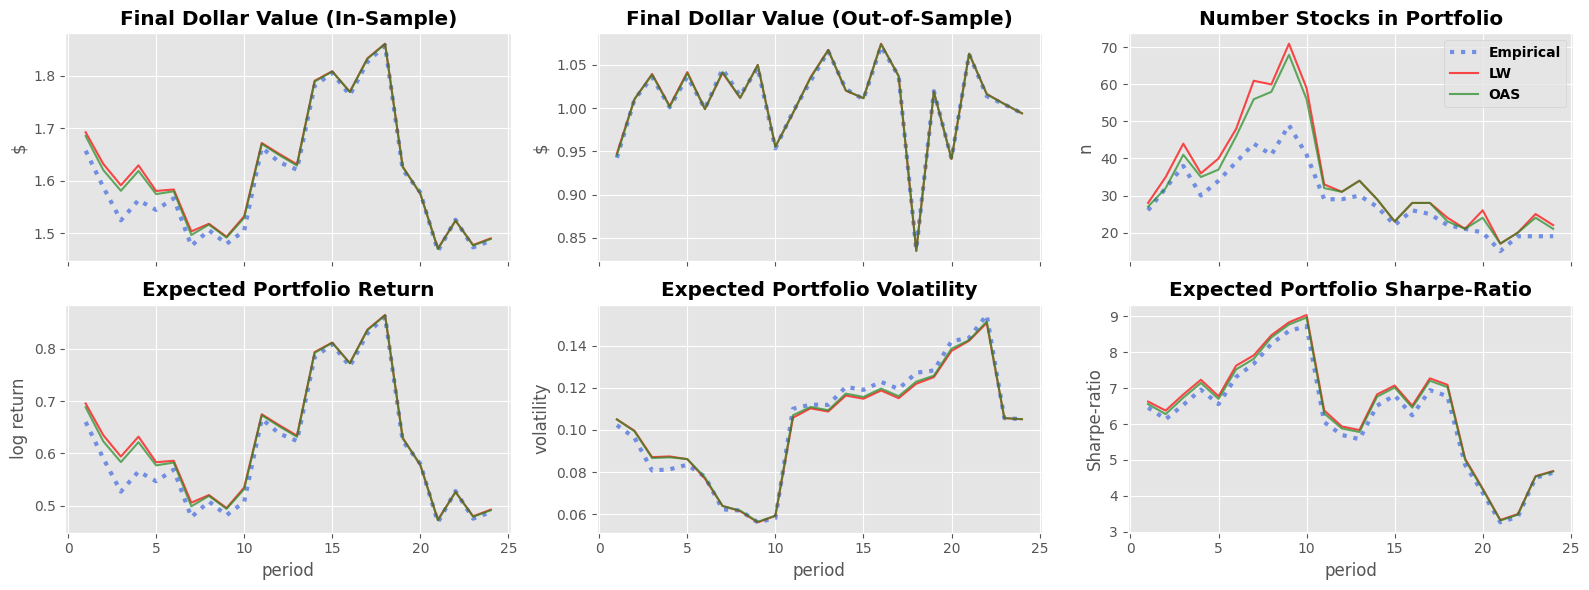

In [34]:
fig, ax = plt.subplots(2,3, figsize=(16, 6), sharex=True)

color_lst = ['royalblue', 'red', 'forestgreen']

for col, method in enumerate(cov_methods):
    if method == 'Empirical':
        linestyle = ':'
        linewidth = 3
    else:
        linestyle = '-'
        linewidth = 1.5
        
    ax[0, 0].plot(results_eval[method]['dollar_val_is'],
                  label=method, c=color_lst[col], alpha=.7, 
                  linestyle=linestyle, linewidth=linewidth)
    ax[0, 0].set_title('Final Dollar Value (In-Sample)', fontweight='bold')
    ax[0, 0].set_ylabel('$')
    
    ax[0, 1].plot(results_eval[method]['dollar_val_oos'],
                  label=method, c=color_lst[col], alpha=.7, 
                  linestyle=linestyle, linewidth=linewidth)
    ax[0, 1].set_title('Final Dollar Value (Out-of-Sample)', fontweight='bold')
    ax[0, 1].set_ylabel('$')
    
    ax[0, 2].plot(results_eval[method]['weights_count'],
                  label=method, c=color_lst[col], alpha=.7, 
                  linestyle=linestyle, linewidth=linewidth)
    ax[0, 2].set_title('Number Stocks in Portfolio', fontweight='bold')
    ax[0, 2].set_ylabel('n')
    
    ax[1, 0].plot(results_eval[method]['pf_mu'],
                  label=method, c=color_lst[col], alpha=.7, 
                  linestyle=linestyle, linewidth=linewidth)
    ax[1, 0].set_title('Expected Portfolio Return', fontweight='bold')
    ax[1, 0].set_xlabel('period')
    ax[1, 0].set_ylabel('log return')
    
    ax[1, 1].plot(results_eval[method]['pf_std'],
                  label=method, c=color_lst[col], alpha=.7, 
                  linestyle=linestyle, linewidth=linewidth)
    ax[1, 1].set_title('Expected Portfolio Volatility', fontweight='bold')
    ax[1, 1].set_xlabel('period')
    ax[1, 1].set_ylabel('volatility')
    
    ax[1, 2].plot(results_eval[method]['pf_sharpe'],
                  label=method, c=color_lst[col], alpha=.7, 
                  linestyle=linestyle, linewidth=linewidth)
    ax[1, 2].set_title('Expected Portfolio Sharpe-Ratio', fontweight='bold')
    ax[1, 2].set_xlabel('period')
    ax[1, 2].set_ylabel('Sharpe-ratio')

ax[0, 2].legend(prop={'weight':'bold'})
fig.tight_layout()

As one can observe, the LW (red line) and OAS (green line) methods result both in a higher expected return, which translates into a higher final dollar value for the in-sample period. This does not hold for the out-of-sample period, where actually the empirical covariance matrix (blue dotted line) yields a slightly higher final dollar value. However, it needs to be mentioned that here only the historical returns are used as a proxy, which is certainly not an optimal solution.  
Further, the number of included stocks in the portfolio is higher for the LW and OAS estimators.

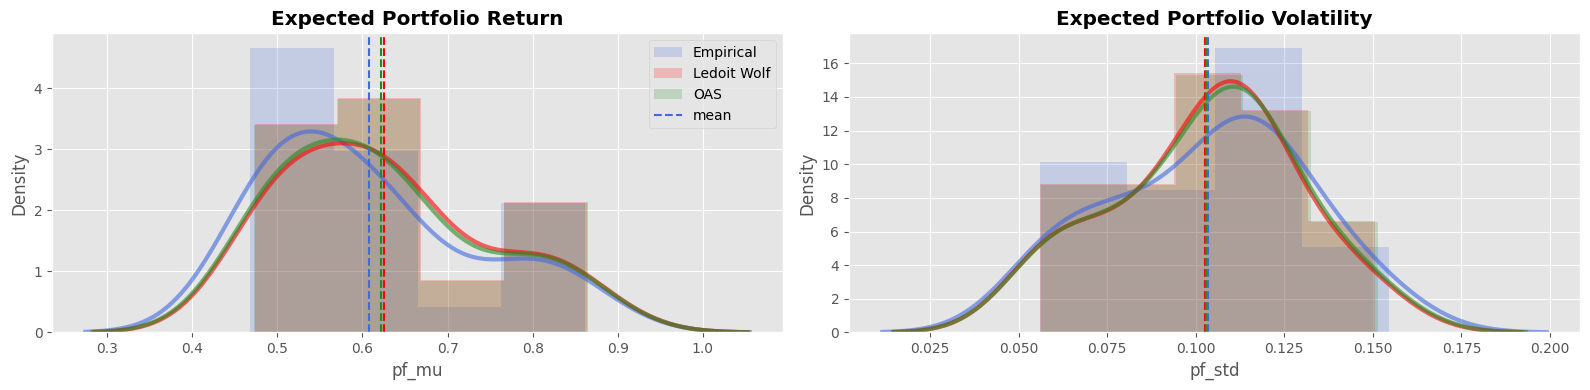

In [35]:
fig, ax = plt.subplots(1,2, figsize=(16, 4))

# return
sns.distplot(results_eval['Empirical']['pf_mu'], 
             kde_kws={"color": "royalblue", "lw": 3, "alpha": .6},
             hist_kws={"color": "royalblue", "alpha": .2},
             label='Empirical', ax=ax[0])
sns.distplot(results_eval['LW']['pf_mu'], 
             kde_kws={"color": "red", "lw": 3, "alpha": .6},
             hist_kws={"color": "red", "alpha": .2},
             label='Ledoit Wolf', ax=ax[0])
sns.distplot(results_eval['OAS']['pf_mu'], 
             kde_kws={"color": "forestgreen", "lw": 3, "alpha": .6},
             hist_kws={"color": "forestgreen", "alpha": .2},
             label='OAS', ax=ax[0])
ax[0].set_title('Expected Portfolio Return', fontweight='bold')
ax[0].axvline([results_eval['Empirical']['pf_mu'].mean()], 
              color='royalblue', linestyle='--', label='mean')
ax[0].axvline([results_eval['LW']['pf_mu'].mean()], 
              color='red', linestyle='--')
ax[0].axvline([results_eval['OAS']['pf_mu'].mean()], 
              color='forestgreen', linestyle='--')
ax[0].legend()

# volatility
sns.distplot(results_eval['Empirical']['pf_std'], 
             kde_kws={"color": "royalblue", "lw": 3, "alpha": .6},
             hist_kws={"color": "royalblue", "alpha": .2},
             label='Empirical', ax=ax[1])
sns.distplot(results_eval['LW']['pf_std'], 
             kde_kws={"color": "red", "lw": 3, "alpha": .6},
             hist_kws={"color": "red", "alpha": .2},
             label='Ledoit Wolf', ax=ax[1])
sns.distplot(results_eval['OAS']['pf_std'], 
             kde_kws={"color": "forestgreen", "lw": 3, "alpha": .6},
             hist_kws={"color": "forestgreen", "alpha": .2},
             label='OAS', ax=ax[1])
ax[1].set_title('Expected Portfolio Volatility', fontweight='bold')
ax[1].axvline([results_eval['Empirical']['pf_std'].mean()], 
              color='royalblue', linestyle='--')
ax[1].axvline([results_eval['LW']['pf_std'].mean()], 
              color='red', linestyle='--')
ax[1].axvline([results_eval['OAS']['pf_std'].mean()], 
              color='forestgreen', linestyle='--')

fig.tight_layout();

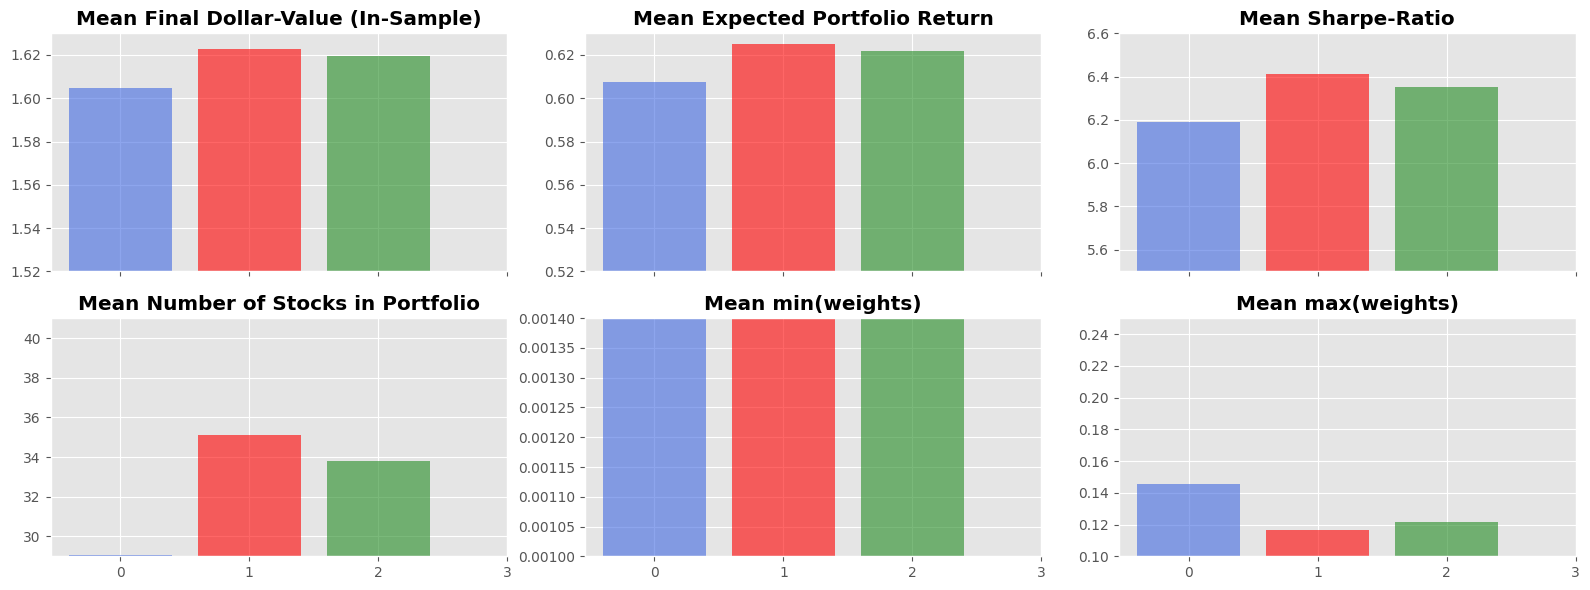

In [36]:
mean_res = np.array([results_eval[method].mean().values for method in cov_methods])

fig, ax = plt.subplots(2,3, figsize=(16, 6), sharex=True)

ax[0, 0].bar(np.arange(3), mean_res[:,0], color=color_lst,
            alpha=.6)
ax[0, 0].set_ylim([1.52, 1.63])
ax[0, 0].set_title('Mean Final Dollar-Value (In-Sample)', fontweight='bold')

ax[0, 1].bar(np.arange(3), mean_res[:,2], color=color_lst,
            alpha=.6)
ax[0, 1].set_ylim([.52, .63])
ax[0, 1].set_title('Mean Expected Portfolio Return', fontweight='bold')

ax[0, 2].bar(np.arange(3), mean_res[:,4], color=color_lst,
            alpha=.6)
ax[0, 2].set_ylim([5.5, 6.6])
ax[0, 2].set_title('Mean Sharpe-Ratio', fontweight='bold')


ax[1, 0].bar(np.arange(3), mean_res[:,5], color=color_lst,
             alpha=.6)
ax[1, 0].set_ylim([29, 41])
ax[1, 0].set_title('Mean Number of Stocks in Portfolio', fontweight='bold')

ax[1, 1].bar(np.arange(3), mean_res[:,6], color=color_lst,
             alpha=.6)
ax[1, 1].set_ylim([.001, .0014])
ax[1, 1].set_title('Mean min(weights)', fontweight='bold')

ax[1, 2].bar(np.arange(3), mean_res[:,7], color=color_lst,
             alpha=.6)
ax[1, 2].set_ylim([.1, .25])
ax[1, 2].set_title('Mean max(weights)', fontweight='bold')

    
for ax_ in ax.reshape(-1): 
    # ax_.set_xticklabels(cov_methods)
    ax_.set_xticks(np.arange(4))

fig.tight_layout();

## Ressources
[1] Ledoit, Wolf. (2003). Honey, I Shrunk the Sample Covariance Matrix.   

[2] Ledoit, Wolf. (2004). A well-conditioned estimator for large-dimensional covariance matrices. Journal of Multivariate Analysis 88.  

[3] Chen et. al. (2010) Shrinkage Algorithms for MMSE Covariance Estimation. IEEE Transactions on signal processing, Vol. 58, No. 10 

[4] Kwan. (2011). An Introduction to Shrinkage Estimation of the Covariance Matrix: A Pedagogic Illustration. Spreadsheets in Education Vol. 4  

[5] Pappas, et. al. (2010). Optimal Portfolio Selection with Singular Covariance Matrix. International Mathematical Forum no. 47.  

[6] Hilpisch. (2015). Python for Finance. O'Reilly.  
